# Sampling and Identifying a Quadratic in Trans-C

In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize

from pyTransC import TransC_Sampler

In [2]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

In [3]:
# setting global parameter controls
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling
autopseudo = True    # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False     # Thin internally generated within state posterior ensembles by their auto-correlation 
                     # (This can take additional compute time, and is not necessary if input ensembles are already independent.)

## Generating the Synthetic Data

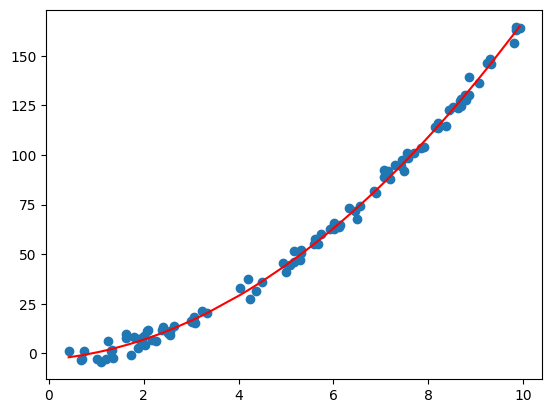

In [4]:
# Generating the initial data
np.random.seed(128)

# true parameters
x0_true = -3
x1_true = 2
x2_true = 1.5

# generating 100 points of the synthetic data
N = 100
sigma = 3 # standard deviation of the noise
x = np.sort(10 * np.random.rand(N)) # generating 100 uniformly distributed random samples between 0 and 10
noise = sigma * np.random.randn(N) # generating some normally-distributed noise
y = x0_true + x1_true * x + x2_true * x**2 + noise # generating the synthetic data with noise

# intial plotting
plt.scatter(x, y, label='Synthetic Data')
plt.plot(x, x0_true + x1_true * x + x2_true * x**2, label='True Model', color='red')
plt.show()


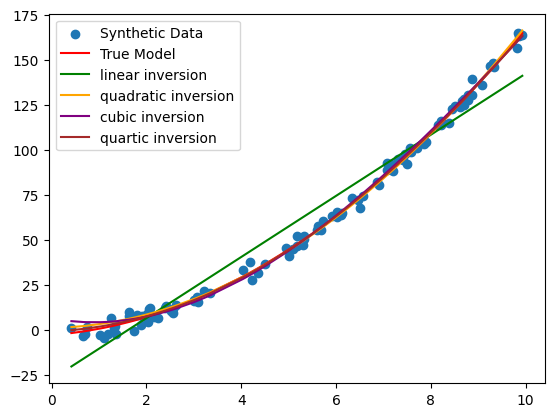

In [5]:
# intial plotting
plt.scatter(x, y, label='Synthetic Data')
plt.plot(x, x0_true + x1_true * x + x2_true * x**2, label='True Model', color='red')

plt.plot(x, -27.542 + 16.979*x, label='linear inversion', color='green')
plt.plot(x, 0.950 + 0.46*x + 1.63*x**2, label='quadratic inversion', color='orange')
plt.plot(x, 6.30 + -5.02*x + 2.92*x**2 + -0.083*x**3, label='cubic inversion', color='purple')
plt.plot(x, -1.08 + 1.27*x + 1.40*x**2 + 0.049*x**3 + -0.0035*x**4, label='quartic inversion', color='brown')

plt.legend()

plt.show()


## Setting up for the Sampling

In [6]:
# we want to test this data's fit across 0 - 4 order polynomials

## Ive changed up the mu to resemble the inversion results more, and I've changed the sigmas to all be 10 rather than 10, 3, 1, 0.5
## maybe that was the issue, the linear state got a lot more freewill than the others? 

# problem setup
nstates = 4 # number of states to sample
ndims = [2, 3, 4, 5] # number of model parameters for each of the states
sigmas = [10, 10, 10, 10] # << this is arbirtrary, look at the data and see what makes sense 
# (perhaps compare to inverted best relations of each type and estimate average amount of error)

mu = [] # list of the means of each prior in each state - this combined with covariances is the prior
for i in range(nstates):
    mu_0 = np.zeros(ndims[i]) # this is also kind of a placeholder, if it looks bad then change this 
    # # I guess by looking at feasible solutions
    # mu_0[0] = 40 # about halfway up the data
    
    if i == 0:
        mu_0[0] = 40
        mu_0[1] = 0
    
    elif i == 1:
        mu_0[0] = 40
        mu_0[1] = 0
        mu_0[2] = 0
    
    elif i == 2:
        mu_0[0] = 40
        mu_0[1] = 0
        mu_0[2] = 0
        mu_0[3] = 0
        
    elif i == 3:
        mu_0[0] = 40
        mu_0[1] = 0
        mu_0[2] = 0
        mu_0[3] = 0
        mu_0[4] = 0
    mu.append(mu_0)
     
#cov = [np.diag(np.ones(ndims[i])*sigmas[i]**2) for i in range(nstates)] # covariance matrices for each state
# covariance matrices stuff - assuming diagonal matrices here
cov = [np.eye(ndims[i])*sigmas[i]**2 for i in range(nstates)] # covariance matrices for each state
cdinv = [np.eye(len(x))/sigmas[i]**2 for i in range(nstates)] # inverse data covariance matrix

Glist = [] # list of the G matrices for each state - I will construct this bespokely
# G 0 order y = x0 << this seemed to be causing issues, so come back to it later
#G0 = np.transpose([np.ones(len(x))]) # previously np.transpose
#Glist.append(G0)
# G 1 order y = x0 + x1*x
G1 = np.transpose([np.ones(len(x)), x])
Glist.append(G1)
# G 2 order y = x0 + x1*x + x2*x^2
G2 = np.transpose([np.ones(len(x)), x, x*x])
Glist.append(G2)
# G 3 order y = x0 + x1*x + x2*x^2 + x3*x^3
G3 = np.transpose([np.ones(len(x)), x, x*x, x*x*x])
Glist.append(G3)
# G 4 order y = x0 + x1*x + x2*x^2 + x3*x^3 + x4*x^4
G4 = np.transpose([np.ones(len(x)), x, x*x, x*x*x, x*x*x*x])
Glist.append(G4)


In [7]:
# einsum python function to help with the matrix multiplication

In [8]:
cov_dets = [np.linalg.det(cov[i]) for i in range(nstates)]
cdinv_dets = [np.linalg.det(cdinv[i]) for i in range(nstates)]


In [9]:
def log_prior(x,state,ndims,mu,cov,cov_dets,icov=False): # << normalised prior
    '''
    Multi-state log Prior PDF evaluation (normalised) for three multi-dimensional Gaussians (can be more)
    It helps if the covariance matrices are reasonable as then this prior is more reasonable
    ---- normalised normal distribution prior ----
    '''
    mean = mu[state]
    covar = cov[state]
    covar_det = cov_dets[state]
    r = mean-x 
    if(icov):
        if(ndims[state] == 1): 
            log_const = - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar[0])
            out = log_const-0.5 * np.dot(r,r)*(covar[0])
        else:
            log_const = - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar_det) 
            out = log_const-0.5 * np.dot(r, np.dot(covar, r))
    else:
        if(ndims[state] == 1): 
            log_const = - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar[0])
            out = log_const-0.5 * np.dot(r,r)/(covar[0])
        else:
            log_const = - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar_det) 
            out = log_const-0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out
    

In [10]:
def log_likelihood(x, state, y, cdinv, cdinv_dets, Glist):
    '''
    Gaussian log likelihood function - requires you to input the G matrix for each state you want to test
    y is the data going in
    
    '''
    G = Glist[state]
    # print (G.shape)
    # print (x.shape)
    # print ((G @ x).shape)
    # print (np.dot(G, x).shape)
    # print (y.shape)
    r = y - np.dot(G, x)
    # print (cdinv[state].shape)
    # print (r.shape)
    # print (r.T.shape)
    # ll = -0.5*np.dot(r,np.dot(cdinv[state], r)) # if not working change first r to transpose of r
    ll = -.5 * r @ cdinv[state] @ r.T # this is the same as above but using the @ operator for matrix multiplication
    ll += -0.5*len(y)*np.log(2*np.pi) - 0.5*np.log(cdinv_dets[state]) # should it be cdinv or cov?
    return ll

In [11]:
def log_posterior(x, state, y, cdinv, cdinv_dets, Glist, ndims, mu, cov, cov_dets):
    '''
    log posterior = log likelihood + log prior
    '''
    lp = log_likelihood(x, state, y, cdinv, cdinv_dets, Glist) 
    lp += log_prior(x,state,ndims,mu,cov, cov_dets)
    return lp

log_posterior_args = [y, cdinv, cdinv_dets, Glist, ndims, mu, cov, cov_dets]



In [12]:
# finding starting points for the MCMC samplers

# first we optimize each state to find good starting point for all McMC samplers
# optimise by finding the maximum value of the log_posterior function
np.random.seed(42)
if(True):
    
    ml = []
    print("Maximum likelihood estimates:")
    for i in range(nstates):
        obj_fun = lambda *args: -log_posterior(*args)
        initial = np.array(0.2*np.ones(ndims[i])) # arbitrary initial guesses for optimisation
        # you can play about with this number to see if it matters much
        soln = minimize(obj_fun, initial, args=(i, y, cdinv, cdinv_dets, Glist, ndims, mu, cov, cov_dets), method='nelder-mead')
        #print(soln)
        ml.append(soln.x)
        print(soln.x)
        #print("x_ml = {0:.3f}".format(soln.x[0]))

Maximum likelihood estimates:
[-27.54250897  16.97973728]
[0.94990057 0.4630726  1.62808749]
[ 6.30447958 -5.01983083  2.91610113 -0.08339889]
[-1.08107948  1.27415427  1.40287082  0.0487083  -0.00349808]


In [13]:
# setting up the psuedo prior function
# we set autospeudoprior to true so this is reasonably straightforward

if(autopseudo): # Automatic pseudo prior function
    nwalkers_auto = 32                                  # Number of walkers for auto pseudo prior fitting
    nsteps_auto = 1000                                  # Number of chain steps for auto pseudo prior fitting
    pos_states = np.random.choice(np.arange(nstates),nwalkers_auto) 
    # Initial states of each walker for auto pseudo prior fitting
    pos = []
    for i in range(nstates): # generate starting points for each chain in each state
        pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers_auto, ndims[i])) 
        # add random perturbation to maximum Likelihood models
    
    tcs = TransC_Sampler(nstates,ndims) # create instances of states
    auto_log_pseudo_prior = tcs.build_auto_pseudo_prior(pos,log_posterior,log_posterior_args=log_posterior_args,
                                nwalkers=nwalkers_auto,nsamples=nsteps_auto,autothin=autothin,parallel=parallel)

    log_pseudo_prior_args = []   # additional argument list beyond (x,state) for log_pseudo_prior function

    def log_pseudo_prior(x,state,returndeviate=False): # multi-state log p-p density and deviate generator
        return auto_log_pseudo_prior(x,state,returndeviate=returndeviate)

else:  # A Gaussian pseudo prior within each model state << this isn't set up for this question at the moment

    def log_pseudo_prior(x,state,ndims,returndeviate=False):  # multi-state log p-p density and deviate generator
        mu = [[0.6],[0.7,0.7,0.7],[0.2,0.2,0.2,0.2,0.2]]                  # Gaussian means for each state
        sig = [0.025,0.055,0.085]                     # standard deviations of isotropic Gaussians in each state
        cov = [np.array([sig[0]**2]),np.diag(np.ones(ndims[1])*sig[1]**2),
                np.diag(sig[2]**2*np.ones(ndims[2]))]                       # covariance matrices for each state
        if(returndeviate):
            x = stats.multivariate_normal.rvs(mean=mu[state],cov=cov[state]) # spherical multi-d Gaussian
            logppx = stats.multivariate_normal.logpdf(x,mean=mu[state],cov=cov[state]) # sph. multi-d Gaussian
            if(type(x) != np.ndarray): x = np.array([x]) # deal with 1D case which returns a scalar
            return logppx,x
        else:
            return stats.multivariate_normal.logpdf(x,mean=mu[state],cov=cov[state]) # spherical multi-d Gaussian 

    log_pseudo_prior_args = [ndims]   # additional argument list beyond (x,state)    

## Running the Sampler

In [14]:
# setup of MCMC sampler
nsamples =[50000,50000,50000,50000] # number of samples per chain for sampling of each state
nwalkers = [32,32,32,32] # number of mcmc chains to run simultaneously in each state
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers[i], ndims[i])) # add random perturbation to maximum Likelihood models

In [15]:
# perform initiation of sampler
tcs3 = TransC_Sampler(nstates,ndims) # create instances of states

In [16]:
# first step: run Ensemble sampler in each state
start_time = time.time()
ensemble_per_state, log_posterior_ens = tcs3.run_mcmc_per_state( 
        nwalkers,                                  # int or list containing number of walkers for each state
        nsamples,                                  # number of chain steps per walker
        pos,                                       # starting positions for walkers in each state
        log_posterior,                             # log Likelihood x log_prior
        log_posterior_args=log_posterior_args,     # log posterior additional arguments (optional)
        discard=0,                                 # burnin number of chain steps to discard in eeach state
        autothin=True,                             # thinning value, save every `thin` models
        progress=True)                             # show progress bar for each state
elapsed_time = time.time() - start_time
print(' Elapsed time                                     :', np.round(elapsed_time,2),'s \n')
print(' Number of samples in each state                  :',*[len(tcs3.ensemble_per_state[i]) for i in range(nstates)])


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32, 32]

Number of states being sampled:  4
Dimensions of each state:  [2, 3, 4, 5]


100%|██████████| 50000/50000 [06:29<00:00, 128.37it/s]


 Elapsed time                                     : 1298.34 s 

 Number of samples in each state                  : 94114 79996 63997 53330


In [17]:
# fit a mixture model to each state to get a normalized pseudo prior PDF.
log_pseudo_prior_ens = tcs3.run_fitmixture(ensemble_per_state,log_posterior_ens,reg_covar=0.) 

 State;  0  in  2  dimensions
 State;  1  in  3  dimensions
 State;  2  in  4  dimensions
 State;  3  in  5  dimensions


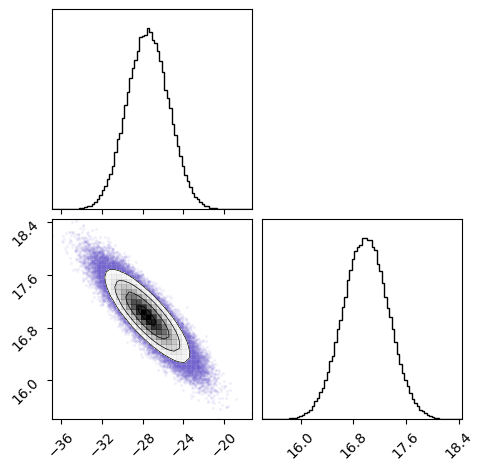

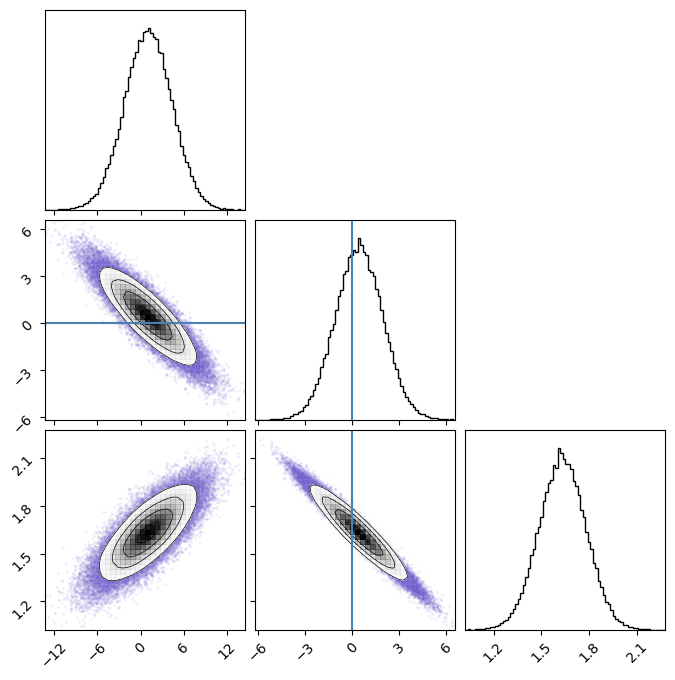

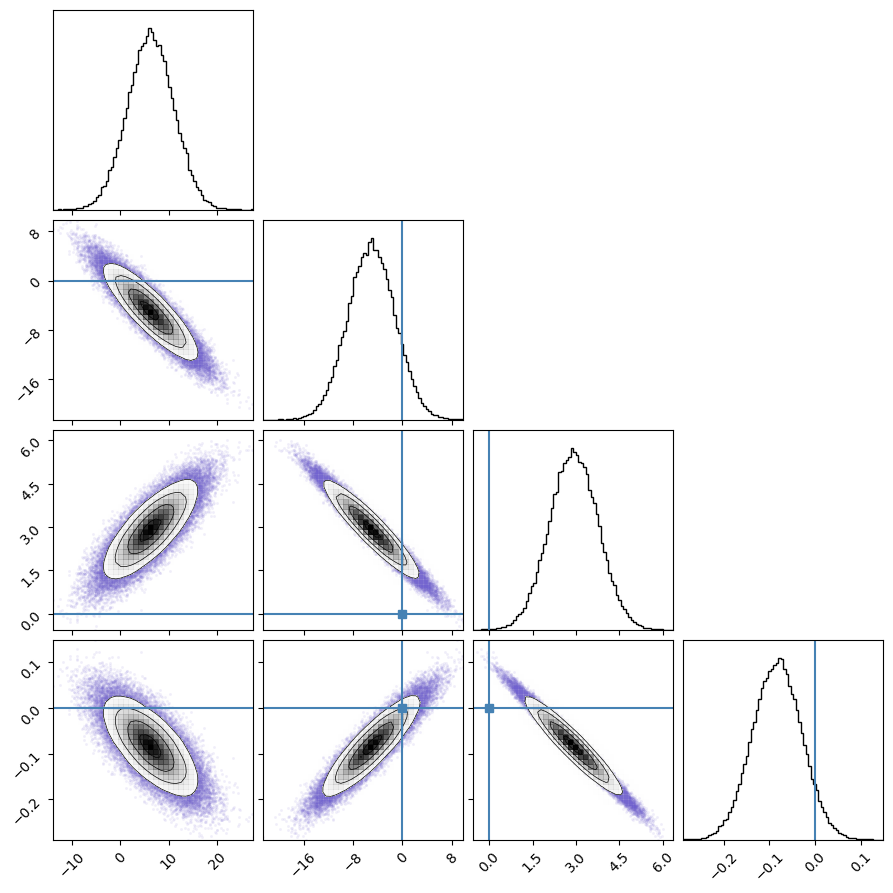

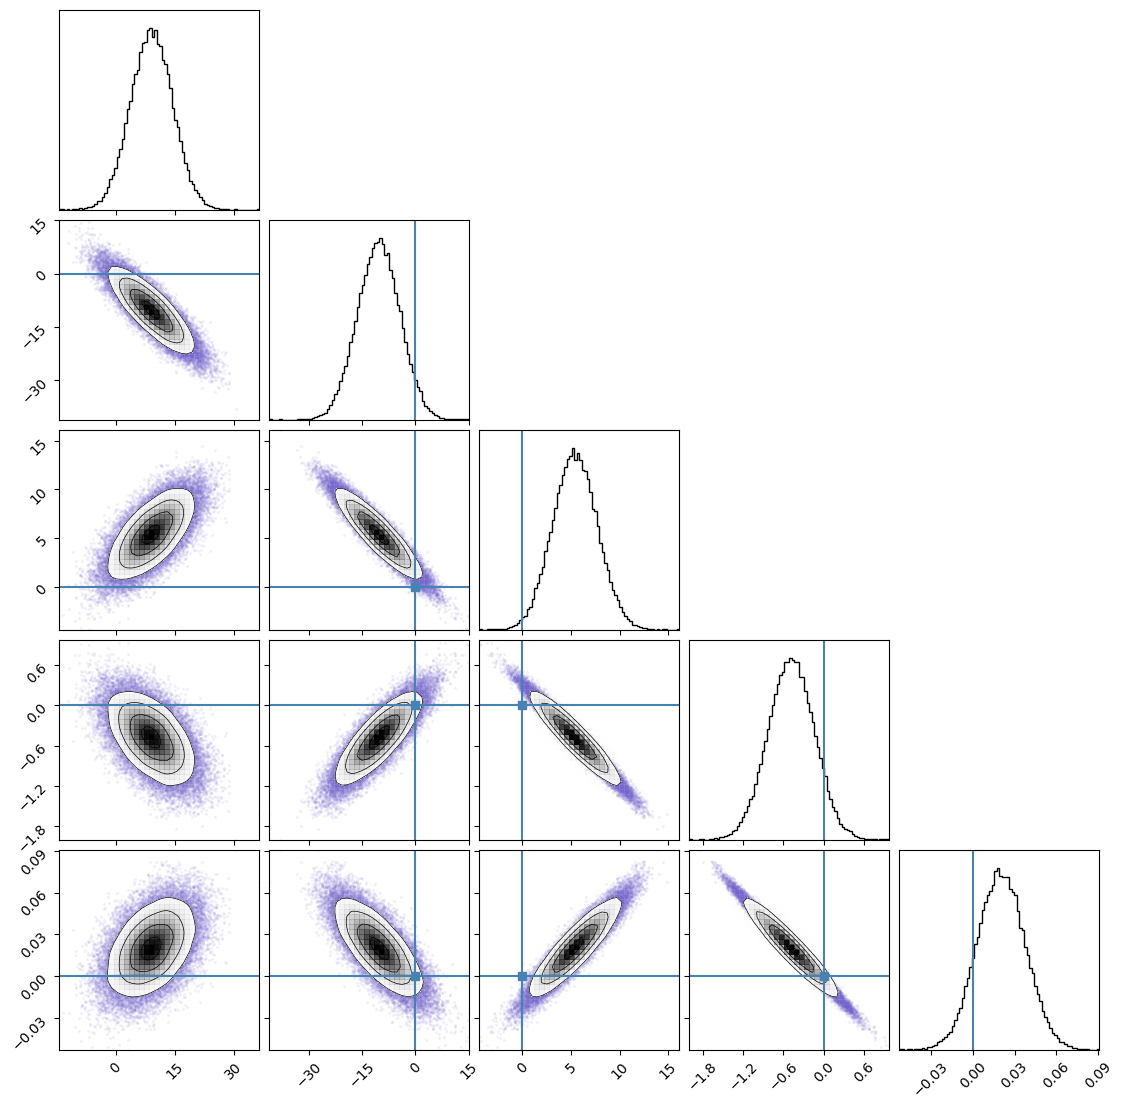

In [18]:
# corner plots to check sampling within each state
if(plotting):
    contour_kwargs = {"linewidths" : 0.5}
    data_kwargs = {"color" : "darkblue"}
    data_kwargs = {"color" : "slateblue"}
    for i in range(nstates):
        string = 'State '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            ensemble_per_state[i], 
            truths=mu[i], # << my Mu aren't truths but maybe this can help calibrate them a bit
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );

In [19]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers = 32   # number of independent random walkers across ensembles
nsteps = 100000 # number of chain steps for each walker
start_time = time.time()
result = tcs3.run_ensemble_resampler(nwalkers,
                                   nsteps,
                                   progress=True,
                                   parallel=parallel,
                                   log_posterior_ens=log_posterior_ens,
                                   log_pseudo_prior_ens=log_pseudo_prior_ens) # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time


Running ensemble trans-D resampler

Number of walkers               :  32
Number of states being sampled  :  4
Dimensions of each state        :  [2, 3, 4, 5]


100%|██████████| 32/32 [01:42<00:00,  3.19s/it]


In [20]:
# print some diagnostics
print('\n Algorithm type                                      :', tcs3.alg)
print(' Average % acceptance rate for within states         :',np.round(tcs3.accept_within,2))
print(' Average % acceptance rate for between states        :',np.round(tcs3.accept_between,2))

# extract trans-D samples and chains
discard = 0                  # chain burnin
thin = 15                    # chain thinning
chain,states_chain = tcs3.get_visits_to_states(discard=discard,thin=thin,normalize=True,
                                               walker_average='median',return_samples=True)

print(' Auto correlation time for between state sampling    :',np.round(tcs3.autocorr_time_for_between_state_jumps,3))
print(' Total number of state changes for all walkers       :',tcs3.total_state_changes)
#print(' Number of state changes for each walker             :\n',*tcs3.state_changes_perwalker)
#print(' True relative marginal Likelihoods                  :', *trueML)
print(' Estimated relative evidences                        :', *np.round((tcs3.relative_marginal_likelihoods),5))
print(' Elapsed time                                        :', np.round(elapsed_time,2),'s \n')


 Algorithm type                                      : TransC-ensemble-resampler
 Average % acceptance rate for within states         : 100.0
 Average % acceptance rate for between states        : 1.2
 Auto correlation time for between state sampling    : 4.96
 Total number of state changes for all walkers       : 7434
 Estimated relative evidences                        : 0.0 0.98182 0.01811 7e-05
 Elapsed time                                        : 102.18 s 



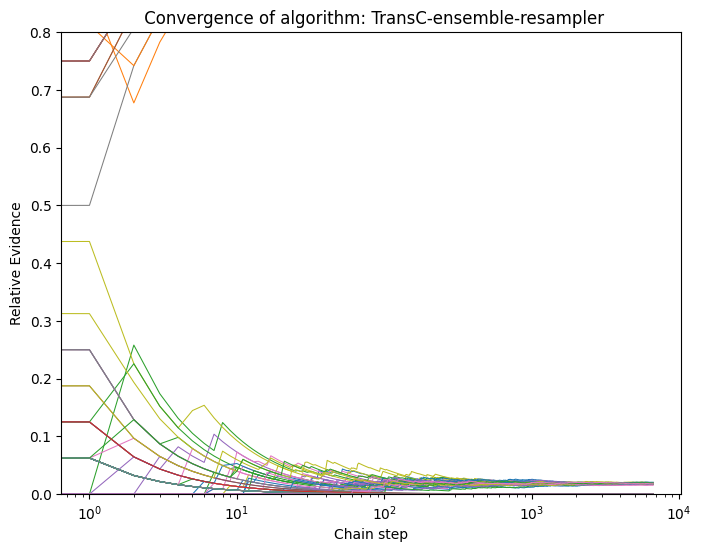

In [21]:
# plot relative number of visit to each state along the chain
if(plotting):
    key = tcs3
    fig, axes = plt.subplots(figsize=(8,6))
    if(chain.ndim == 3): # plot chains for each state and walker
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75)
    elif(chain.ndim==2): # plot chains for each state average over walkers
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75,label=['State 1','State 2','State 3'])
        plt.legend()
    plt.xlabel('Chain step')
    plt.ylabel('Relative Evidence')
    #plt.plot(len(chain)*1.3,trueML[0],'bo')
    #plt.plot(len(chain)*1.3,trueML[1],'o',color='orange')
    #plt.plot(len(chain)*1.3,trueML[2],'go')
    plt.title(' Convergence of algorithm: '+key.alg)
    plt.ylim(0.0,0.8)

    #plt.savefig('convergence_ensemble_3-5-10.pdf')
    plt.show()


 Generating trans-dimensional ensemble of size  100000  using algorithm:  TransC-ensemble-resampler 



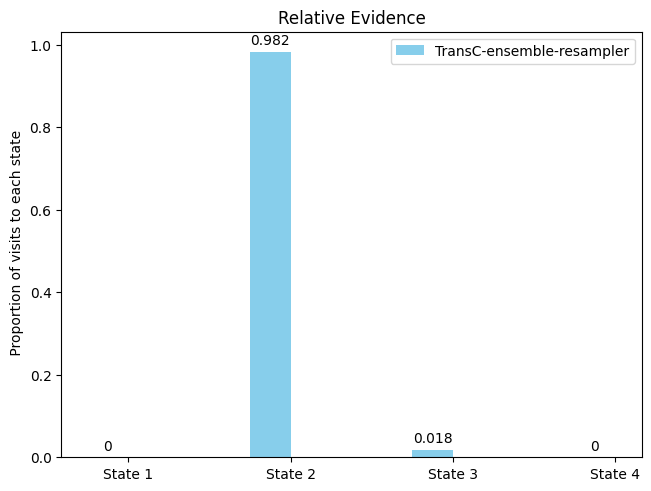

In [22]:
if(plotting):
    # extract trans-D sample
    transc_ensemble,model_chains,states_chain = tcs3.get_transc_samples(100000,returnchains=True,verbose=True)# Count visits to each state by Trans-D mcmc
    
    h=np.zeros(tcs3.nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(Counter(states_chain.reshape(-1)).values())
    h/=np.sum(h)

    # plot histogram of frequency of visits to each state

    labels = ("State 1", "State 2", "State 3")
    labels = ['State '+str(i+1) for i in np.arange(nstates)]

    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h,3), width, label=tcs3.alg,color='skyblue')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier+0.05
    # rects = ax.bar(x + offset, np.round(trueML,3), width, label='True',color='seagreen')
    # ax.bar_label(rects, padding=3)
    # multiplier += 1


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(' Proportion of visits to each state')
    ax.set_title('Relative Evidence')
    ax.set_xticks(x + width/2, labels)
    ax.legend(loc='upper right')
    #ax.set_ylim(0.,np.max(np.maximum(h,trueML))*1.1)
    #plt.savefig('Marginal_Likelihoods.png')
    plt.show()

In [23]:
# # corner plots to check sampling within each state
# if(plotting):
#     for i in range(nstates):
#         string = 'State '+str(i)
#         print(' State; ',i,' in ',ndims[i],' dimensions')
#         fig = corner.corner(
#             transc_ensemble[i], 
#             truths=mu[i],
#             title=string,
#             bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
#             );

In [24]:
print(' Here is the Trans-C ensemble with\n {} samples in state 1\n {} samples in state 2\n {} samples in state 3\n {} samples in state 4\n'\
      .format(len(transc_ensemble[0]),len(transc_ensemble[1]),len(transc_ensemble[2]),len(transc_ensemble[3])),'\n',transc_ensemble)

 Here is the Trans-C ensemble with
 0 samples in state 1
 98214 samples in state 2
 1781 samples in state 3
 5 samples in state 4
 
 [array([], dtype=float64), array([[ 5.66458022, -1.62943483,  1.78585145],
       [-1.87883215,  2.14453896,  1.44168875],
       [ 1.89667646,  0.95743839,  1.51919603],
       ...,
       [-0.63979835,  1.22967573,  1.56939047],
       [ 1.81885782,  0.31353857,  1.5926536 ],
       [ 2.58847257,  1.0935734 ,  1.51992915]]), array([[ 3.07990494e+00,  1.41274197e-01,  1.58432012e+00,
         2.77245083e-03],
       [ 7.67789784e+00, -6.67134308e+00,  3.29387579e+00,
        -1.06850410e-01],
       [ 1.83102856e-01, -1.54983171e+00,  2.45805348e+00,
        -6.70152342e-02],
       ...,
       [ 6.66220019e+00, -3.89867960e+00,  2.47404621e+00,
        -5.03758420e-02],
       [ 8.34512567e+00, -3.68710257e+00,  2.43495881e+00,
        -4.80589777e-02],
       [ 8.60737532e+00, -6.10653325e+00,  3.19643030e+00,
        -1.00811515e-01]]), array([[ 1.426

In [25]:
# trans-c sampled parameters

print(f'param 0: {np.mean(transc_ensemble[1][:,0])}')
print(f'param 1: {np.mean(transc_ensemble[1][:,1])}')
print(f'param 2: {np.mean(transc_ensemble[1][:,2])}')

param 0: 1.0157770401886121
param 1: 0.43069697439748794
param 2: 1.631199095388829


In [26]:
# individual ensemble sampled parameters

print(f'param 0: {np.mean(ensemble_per_state[1][:,0])}')
print(f'param 1: {np.mean(ensemble_per_state[1][:,1])}')
print(f'param 2: {np.mean(ensemble_per_state[1][:,2])}')

param 0: 1.019287675176491
param 1: 0.4296369048366545
param 2: 1.6313060911403439


In [27]:
print(f'param 0: {np.median(ensemble_per_state[1][:,0])}')
print(f'param 1: {np.median(ensemble_per_state[1][:,1])}')
print(f'param 2: {np.median(ensemble_per_state[1][:,2])}')

param 0: 1.0253043193954716
param 1: 0.42768050032122074
param 2: 1.6310785988426018
